In [1]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import *
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
import matplotlib.pyplot as plt

def load_dataset(data_set):
    mat = {k: v for k, v in data_set.items() if k[0] != '_'}
    data = pd.DataFrame({k: pd.Series(v[:, 0]) for k, v in mat.items()})

    # Prepare the data
    data1 = data[["DayCode1", "Occupation1", "Power1"]]
    data2 = data[["DayCode2", "Occupation2", "Power2"]]
    data1 = data1.rename(
        columns={"DayCode1": "DayCode", "Occupation1": "Occupation", "Power1": "Power"})
    data2 = data2.rename(
        columns={"DayCode2": "DayCode", "Occupation2": "Occupation", "Power2": "Power"})
    data = pd.concat([data2, data1])
    data = data.dropna(axis=0)
    return data


load_dataset(loadmat("LCAlgarve.mat"))

,DayCode,Occupation,Power
0,0.8,5.0,0.747135
1,0.8,5.0,1.370311
2,0.8,5.0,0.759630
3,0.8,5.0,1.125687
4,0.8,5.0,1.910926
...,...,...,...
1249,0.8,3.0,2.131813
1250,0.8,3.0,0.410176
1251,0.8,3.0,0.293854
1252,0.8,3.0,0.378586


In [2]:
def scaling_data(data):
    scaler = RobustScaler()
    scaler = scaler.fit(np.asarray(data[['Power', 'Occupation']]))
    data[['Power', 'Occupation']] = scaler.transform(
        np.asarray(data[['Power', 'Occupation']]))
    return data[['Power', 'Occupation']]


data = load_dataset(loadmat("LCAlgarve.mat"))
scaling_data(data)

,Power,Occupation
0,-0.536837,2.0
1,0.034973,2.0
2,-0.525372,2.0
3,-0.189488,2.0
4,0.531026,2.0
...,...,...
1249,0.733706,0.0
1250,-0.846021,0.0
1251,-0.952756,0.0
1252,-0.875008,0.0


### Function to create dataset after sampling for forecast
The objective is to forecast the house electricity consumption (and optionally, occupation) for the next 12 hours using historical data sampled every 15 minutes.

In [3]:
def create_dataset(data,lookback, horizon):
    X = []
    y_power = []
    y_occupation = []
    for i in range(len(data) - lookback - horizon + 1):
        X.append(data[['Occupation', 'Power']].values[i:(i + lookback), :])
        y_power.append(data['Power'].values[(
            i + lookback):(i + lookback + horizon)])
        y_occupation.append(data['Occupation'].values[(
            i + lookback):(i + lookback + horizon)])
    X = np.array(X)
    y_power = np.array(y_power)
    y_occupation = np.array(y_occupation)
    return X, y_power, y_occupation


lookback = 380  
# Explanation: 24 hours * 4 (15-minute intervals per hour)
# The dataset is sampled every 15 minutes, so there are 4 samples per hour.
# For a 24-hour period, we need 24 hours * 4 samples/hour = 96 samples.
# By setting lookback = 380, we are considering a period of 380 / 4 ≈ 95 hours, 
# which is approximately 4 days worth of historical data.
horizon = 48    
# 12 hours ahead * 4 (15-minute intervals per hour)
# Explanation: The dataset is sampled every 15 minutes, so there are 4 samples per hour.
# To predict for the next 12 hours, we need 12 hours * 4 samples/hour = 48 samples.
# By setting horizon = 48, we are defining that the model should predict the next 48 samples, 
# which corresponds to 12 hours ahead.


X, y_power, y_occupation = create_dataset(data, lookback, horizon)
# Split the data into training and testing sets
train_size = int(len(X) * 0.9)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
y_train_power, y_test_power = y_power[:train_size], y_power[train_size:]
y_train_occupation, y_test_occupation = y_occupation[:
                                                     train_size], y_occupation[train_size:]

# Reshape X for MLPRegressor and SVR
X_train_flat = X_train.reshape((X_train.shape[0], -1))
X_test_flat = X_test.reshape((X_test.shape[0], -1))

In [4]:
# Function for training and predicting for each step in the horizon
def model_prediction(model):
    predictions_power = []
    predictions_occupation = []
    for step in range(horizon):
        model_power = model.__class__(**model.get_params())
        model_occupation = model.__class__(**model.get_params())
        model_power.fit(X_train_flat, y_train_power[:, step])
        model_occupation.fit(X_train_flat, y_train_occupation[:, step])
        predictions_power.append(model_power.predict(X_test_flat))
        predictions_occupation.append(model_occupation.predict(X_test_flat))
    y_pred_power = np.array(predictions_power).T
    y_pred_occupation = np.array(predictions_occupation).T
    return y_pred_power, y_pred_occupation


# Train and predict using MLPRegressor
mlp_model = MLPRegressor(hidden_layer_sizes=(
    100, 50), max_iter=500, random_state=42)
y_pred_mlp_power, y_pred_mlp_occupation = model_prediction(mlp_model)

# Train and predict using SVR
svr_model = SVR(kernel='rbf')
y_pred_svr_power, y_pred_svr_occupation = model_prediction(svr_model)

In [5]:
# Evaluate the models for power prediction
mse_mlp_power = mean_squared_error(y_test_power, y_pred_mlp_power)
mse_svr_power = mean_squared_error(y_test_power, y_pred_svr_power)

mae_mlp_power = mean_absolute_error(y_test_power, y_pred_mlp_power)
mae_svr_power = mean_absolute_error(y_test_power, y_pred_svr_power)

r2_mlp_power = r2_score(y_test_power, y_pred_mlp_power)
r2_svr_power = r2_score(y_test_power, y_pred_svr_power)

explained_variance_mlp_power = explained_variance_score(
    y_test_power, y_pred_mlp_power)
explained_variance_svr_power = explained_variance_score(
    y_test_power, y_pred_svr_power) 

# Evaluate the models for occupation prediction
mse_mlp_occupation = mean_squared_error(
    y_test_occupation, y_pred_mlp_occupation)
mse_svr_occupation = mean_squared_error(
    y_test_occupation, y_pred_svr_occupation)

mae_mlp_occupation = mean_absolute_error(
    y_test_occupation, y_pred_mlp_occupation)
mae_svr_occupation = mean_absolute_error(
    y_test_occupation, y_pred_svr_occupation)

r2_mlp_occupation = r2_score(y_test_occupation, y_pred_mlp_occupation)
r2_svr_occupation = r2_score(y_test_occupation, y_pred_svr_occupation)

explained_variance_mlp_occupation = explained_variance_score(
    y_test_occupation, y_pred_mlp_occupation)
explained_variance_svr_occupation = explained_variance_score(
    y_test_occupation, y_pred_svr_occupation)

print(f'MLP Power Mean Squared Error: {mse_mlp_power}')
print(f'SVR Power Mean Squared Error: {mse_svr_power}')
print(f'MLP Power Mean Absolute Error: {mae_mlp_power}')
print(f'SVR Power Mean Absolute Error: {mae_svr_power}')
print(f'MLP Power R-squared: {r2_mlp_power}')
print(f'SVR Power R-squared: {r2_svr_power}')
print(f'MLP Power Explained Variance: {explained_variance_mlp_power}')
print(f'SVR Power Explained Variance: {explained_variance_svr_power}')

print(f'MLP Occupation Mean Squared Error: {mse_mlp_occupation}')
print(f'SVR Occupation Mean Squared Error: {mse_svr_occupation}')
print(f'MLP Occupation Mean Absolute Error: {mae_mlp_occupation}')
print(f'SVR Occupation Mean Absolute Error: {mae_svr_occupation}')
print(f'MLP Occupation R-squared: {r2_mlp_occupation}')
print(f'SVR Occupation R-squared: {r2_svr_occupation}')
print(
    f'MLP Occupation Explained Variance: {explained_variance_mlp_occupation}')
print(
    f'SVR Occupation Explained Variance: {explained_variance_svr_occupation}')

MLP Power Mean Squared Error: 1.0209960731567145
SVR Power Mean Squared Error: 0.7315169853189868
MLP Power Mean Absolute Error: 0.836601986299772
SVR Power Mean Absolute Error: 0.7162477605991117
MLP Power R-squared: -2.0036934739443932
SVR Power R-squared: -1.1495955858238986
MLP Power Explained Variance: -0.5614704632619211
SVR Power Explained Variance: -0.12967849700614253
MLP Occupation Mean Squared Error: 0.09103045028808805
SVR Occupation Mean Squared Error: 0.03166349536870206
MLP Occupation Mean Absolute Error: 0.22735001699921953
SVR Occupation Mean Absolute Error: 0.13724455706474337
MLP Occupation R-squared: 0.0
SVR Occupation R-squared: 0.0
MLP Occupation Explained Variance: 0.0
SVR Occupation Explained Variance: 0.0


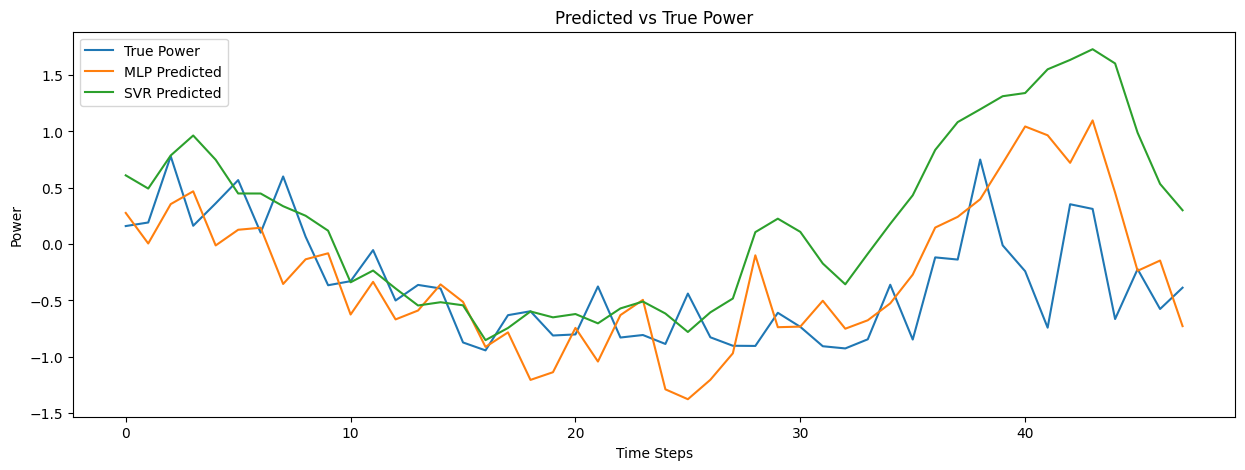

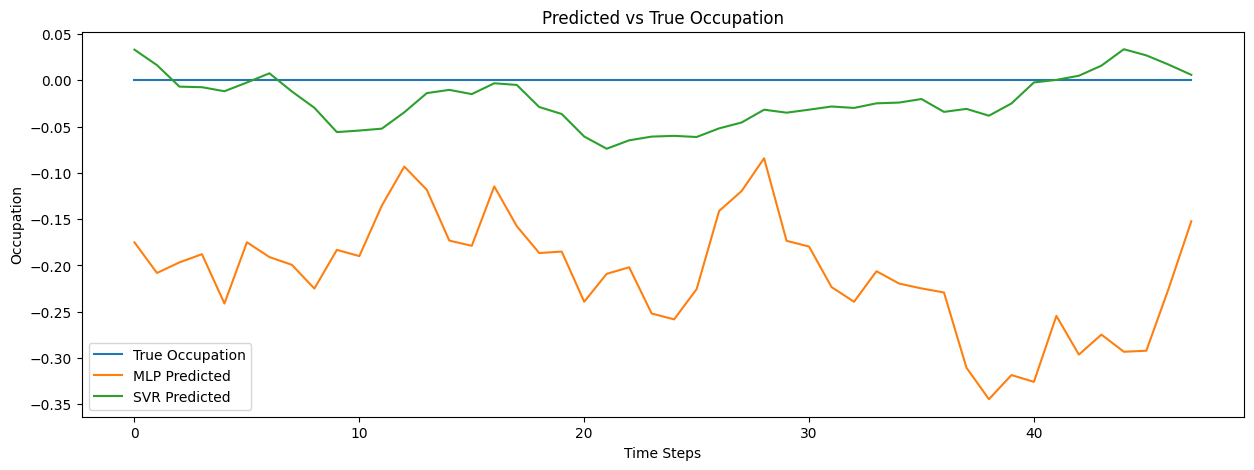

In [6]:
# plot the results
def plot_result(label,y1,y2,y3,l1,l2):
    plt.figure(figsize=(15, 5))
    plt.plot(y1, label=label)
    plt.plot(y2, label='MLP Predicted')
    plt.plot(y3, label='SVR Predicted')
    plt.legend()
    plt.xlabel('Time Steps')
    plt.ylabel(l1)
    plt.title(l2)
    plt.show()


plot_result(label='True Power', y1=y_test_power[0], y2=y_pred_mlp_power[0], y3=y_pred_svr_power[0], l1='Power',l2='Predicted vs True Power')
plot_result(label='True Occupation', y1=y_test_occupation[0], y2=y_pred_mlp_occupation[0],
            y3=y_pred_svr_occupation[0], l1='Occupation', l2='Predicted vs True Occupation')

## Hyperparameter tuning

In [7]:
from sklearn.model_selection import GridSearchCV
# Define parameter grids
mlp_param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50), (50, 100)],
    'max_iter': [200, 500],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive']
}

svr_param_grid = {
    'kernel': ['rbf', 'linear'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}
# Grid search for MLPRegressor
mlp = MLPRegressor(random_state=42)
mlp_grid_search = GridSearchCV(
    mlp, mlp_param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
# Use the first step for grid search
mlp_grid_search.fit(X_train_flat, y_train_power[:, 0])
best_mlp_params = mlp_grid_search.best_params_

# Grid search for SVR
svr = SVR()
svr_grid_search = GridSearchCV(
    svr, svr_param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
# Use the first step for grid search
svr_grid_search.fit(X_train_flat, y_train_power[:, 0])
best_svr_params = svr_grid_search.best_params_

# Train and predict using best MLPRegressor
mlp_best = MLPRegressor(**best_mlp_params, random_state=42)
y_pred_mlp_power, y_pred_mlp_occupation = model_prediction(mlp_best)

# Train and predict using best SVR
svr_best = SVR(**best_svr_params)
y_pred_svr_power, y_pred_svr_occupation = model_prediction(svr_best)

In [9]:
# Evaluate the models for power prediction
mse_mlp_power = mean_squared_error(y_test_power, y_pred_mlp_power)
mse_svr_power = mean_squared_error(y_test_power, y_pred_svr_power)

mae_mlp_power = mean_absolute_error(y_test_power, y_pred_mlp_power)
mae_svr_power = mean_absolute_error(y_test_power, y_pred_svr_power)

r2_mlp_power = r2_score(y_test_power, y_pred_mlp_power)
r2_svr_power = r2_score(y_test_power, y_pred_svr_power)

explained_variance_mlp_power = explained_variance_score(
    y_test_power, y_pred_mlp_power)
explained_variance_svr_power = explained_variance_score(
    y_test_power, y_pred_svr_power)

# Evaluate the models for occupation prediction
mse_mlp_occupation = mean_squared_error(
    y_test_occupation, y_pred_mlp_occupation)
mse_svr_occupation = mean_squared_error(
    y_test_occupation, y_pred_svr_occupation)

mae_mlp_occupation = mean_absolute_error(
    y_test_occupation, y_pred_mlp_occupation)
mae_svr_occupation = mean_absolute_error(
    y_test_occupation, y_pred_svr_occupation)

r2_mlp_occupation = r2_score(y_test_occupation, y_pred_mlp_occupation)
r2_svr_occupation = r2_score(y_test_occupation, y_pred_svr_occupation)

explained_variance_mlp_occupation = explained_variance_score(
    y_test_occupation, y_pred_mlp_occupation)
explained_variance_svr_occupation = explained_variance_score(
    y_test_occupation, y_pred_svr_occupation)

print(f'MLP Power Mean Squared Error: {mse_mlp_power}')
print(f'SVR Power Mean Squared Error: {mse_svr_power}')
print(f'MLP Power Mean Absolute Error: {mae_mlp_power}')
print(f'SVR Power Mean Absolute Error: {mae_svr_power}')
print(f'MLP Power R-squared: {r2_mlp_power}')
print(f'SVR Power R-squared: {r2_svr_power}')
print(f'MLP Power Explained Variance: {explained_variance_mlp_power}')
print(f'SVR Power Explained Variance: {explained_variance_svr_power}')

print(f'MLP Occupation Mean Squared Error: {mse_mlp_occupation}')
print(f'SVR Occupation Mean Squared Error: {mse_svr_occupation}')
print(f'MLP Occupation Mean Absolute Error: {mae_mlp_occupation}')
print(f'SVR Occupation Mean Absolute Error: {mae_svr_occupation}')
print(f'MLP Occupation R-squared: {r2_mlp_occupation}')
print(f'SVR Occupation R-squared: {r2_svr_occupation}')
print(
    f'MLP Occupation Explained Variance: {explained_variance_mlp_occupation}')
print(
    f'SVR Occupation Explained Variance: {explained_variance_svr_occupation}')

MLP Power Mean Squared Error: 1.069034100879959
SVR Power Mean Squared Error: 0.7315169853189868
MLP Power Mean Absolute Error: 0.8567450869983867
SVR Power Mean Absolute Error: 0.7162477605991117
MLP Power R-squared: -2.144013278950895
SVR Power R-squared: -1.1495955858238986
MLP Power Explained Variance: -0.6117327448109137
SVR Power Explained Variance: -0.12967849700614253
MLP Occupation Mean Squared Error: 0.04695480839816107
SVR Occupation Mean Squared Error: 0.03166349536870206
MLP Occupation Mean Absolute Error: 0.1665791482852813
SVR Occupation Mean Absolute Error: 0.13724455706474337
MLP Occupation R-squared: 0.0
SVR Occupation R-squared: 0.0
MLP Occupation Explained Variance: 0.0
SVR Occupation Explained Variance: 0.0


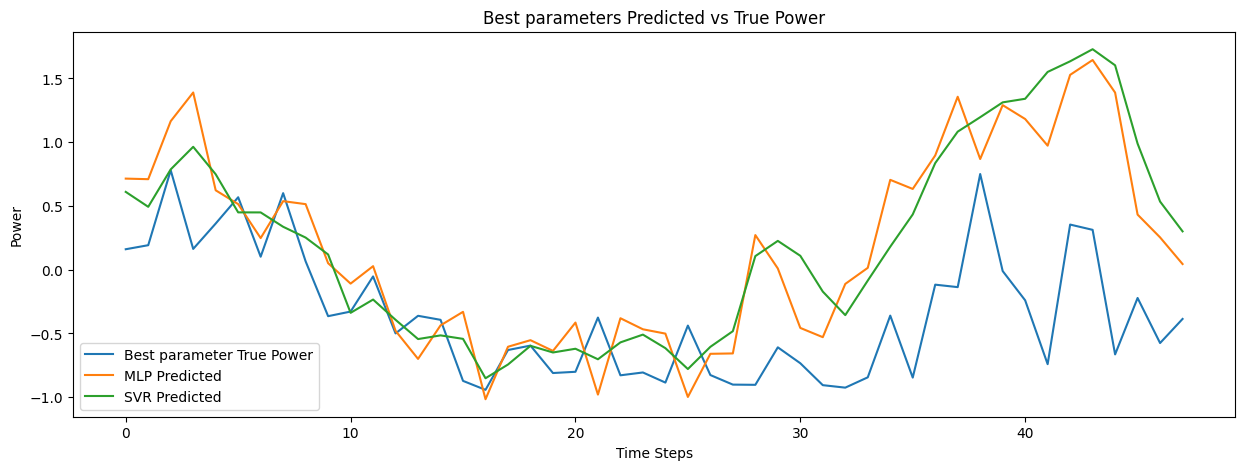

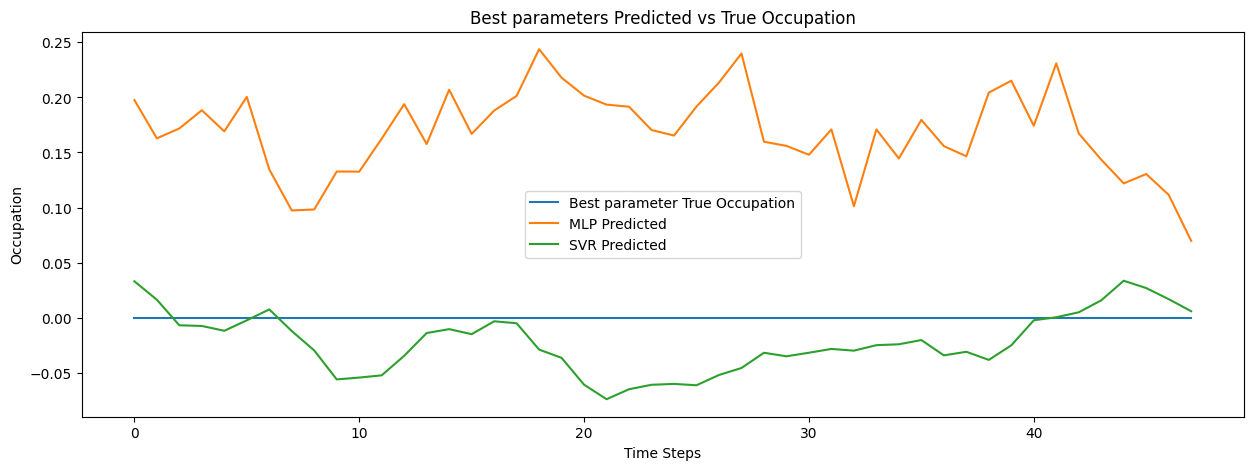

In [8]:
plot_result(label='Best parameter True Power', y1=y_test_power[0], y2=y_pred_mlp_power[0],
            y3=y_pred_svr_power[0], l1='Power', l2='Best parameters Predicted vs True Power')
plot_result(label='Best parameter True Occupation', y1=y_test_occupation[0], y2=y_pred_mlp_occupation[0],
            y3=y_pred_svr_occupation[0], l1='Occupation', l2='Best parameters Predicted vs True Occupation')